<a href="https://colab.research.google.com/github/jngadiub/ML_course_Pavia_23_WIP/blob/main/PartT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jet Tagging with Set Transformer

In this notebook we will see an implementation of the Transformer architecture for sets applied to the jet tagging task. For *sets* it is meant here a point cloud, i.e. a set of nodes without edges. We will instead use Multi-Head Attention to learn which nodes (or particles) have strong pair-wise interaction.

The architecture was introduced by [J. Lee at al. (ICML 2019)](https://arxiv.org/abs/1810.00825) --  specifically designed to model interactions among elements in the input set without pre-defined edges. The model consists of an encoder and a decoder, both of which rely on attention mechanisms, as in the original Transformer implementation [by Vaswani](https://arxiv.org/abs/1706.03762). The main difference is that positional encoding is removed plus some other low level adaptions.

We will use tensorflow for this implementation.

Before you start, choose GPU as a hardware accelerator for this notebook. To do this first go to Edit -> Notebook Settings -> Choose GPU as a hardware accelerator.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import h5py
import numpy as np
import matplotlib.pyplot  as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import roc_curve, auc

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-08-11 00:50:15.579946: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Num GPUs Available:  1


2023-08-11 00:50:17.552974: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-08-11 00:50:17.553588: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-08-11 00:50:17.583625: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:98:00.0 name: NVIDIA A30 computeCapability: 8.0
coreClock: 1.44GHz coreCount: 56 deviceMemorySize: 23.50GiB deviceMemoryBandwidth: 869.04GiB/s
2023-08-11 00:50:17.583641: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-08-11 00:50:17.585056: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-08-11 00:50:17.585095: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-08-11 

In [2]:
# let's open the file
data_dir = 'Data-MLtutorial/JetDataset/'
fileIN = data_dir+'jetImage_7_100p_30000_40000.h5'
f = h5py.File(fileIN,"r")
# and see what it contains
print(list(f.keys()))

['jetConstituentList', 'jetFeatureNames', 'jetImage', 'jetImageECAL', 'jetImageHCAL', 'jets', 'particleFeatureNames']


In [3]:
target_file = np.array(f.get('jets')[0:,-6:-1])
target_reg = np.array(f.get("jets")[0:,3])

*   'jetImage' ,' jetImageECAL' and 'jetImageHCAL' contains the image representation of the jets  . We will not use them today but build our point cloud from the other information.
*   'jetConstituentList' is the list of particles cointained in the jet. For each particle, a list of relevant quantities is stored. This is the dataset we will consider in this notebook.
*   'particleFeatureNames' is the list of the names corresponding to the quantities contained in 'jetConstituentList'
*   'jets' is the list of jets with the high-level jet features stored. We will only use jet ID from it, indecies [-6:-1]
*   'jetFeatureNames' is the list of the names corresponding to the quantities contained in 'jets'. These quantities are build using physics knowledge and correspond to high-level infromation and features per graph (as opposed to per node)

The first 100 highest transverse momentum $p_T$ particles are considered for each jet.



In [4]:
target_onehot = np.array([])
jetList = np.array([])
jetImages = np.array([])
target_reg = np.array([])
features_names = dict()
datafiles = ['jetImage_7_100p_0_10000.h5',
             'jetImage_7_100p_10000_20000.h5',
             'jetImage_7_100p_30000_40000.h5',
             'jetImage_7_100p_40000_50000.h5',
             'jetImage_7_100p_50000_60000.h5',
             'jetImage_7_100p_60000_70000.h5',
             'jetImage_7_100p_70000_80000.h5',
             'jetImage_7_100p_80000_90000.h5'
            ]
for i_f,fileIN in enumerate(datafiles):
    print("Appending %s" %fileIN)
    f = h5py.File(data_dir + fileIN)
    jetList_file = np.array(f.get("jetConstituentList"))
    target_file = np.array(f.get('jets')[0:,-6:-1])
    mass = np.array(f.get("jets")[0:,3])    
    jetImages_file = np.array(f.get('jetImage'))
    jetList = np.concatenate([jetList, jetList_file], axis=0) if jetList.size else jetList_file
    target_onehot = np.concatenate([target_onehot, target_file], axis=0) if target_onehot.size else target_file
    jetImages = np.concatenate([jetImages, jetImages_file], axis=0) if jetImages.size else jetImages_file
    target_reg = np.concatenate([target_reg,mass],axis=0)
    del jetList_file, target_file, jetImages_file, mass
    #save particles/nodes features names and their indecies in a dictionary
    if i_f==0:
      for feat_idx,feat_name in enumerate(list(f['particleFeatureNames'])[:-1]):
        features_names[feat_name.decode("utf-8").replace('j1_','')] = feat_idx
    f.close()

/tmp/ipykernel_134809/3009411415.py:17: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(data_dir + fileIN)


Appending jetImage_7_100p_0_10000.h5
Appending jetImage_7_100p_10000_20000.h5
Appending jetImage_7_100p_30000_40000.h5
Appending jetImage_7_100p_40000_50000.h5
Appending jetImage_7_100p_50000_60000.h5
Appending jetImage_7_100p_60000_70000.h5
Appending jetImage_7_100p_70000_80000.h5
Appending jetImage_7_100p_80000_90000.h5


The ground truth is incorporated in the ['j_g', 'j_q', 'j_w', 'j_z', 'j_t] vector of boolean, taking the form
*  [1, 0, 0, 0, 0] for gluons
*  [0, 1, 0, 0, 0] for quarks
*  [0, 0, 1, 0, 0] for W
*  [0, 0, 0, 1, 0] for Z 
*  [0, 0, 0, 0, 1] for top quarks

This is what is called 'one-hot' encoding of a descrete label (typical of ground truth for classification problems). These labels are the 'target' for our classification tasks. Let's convert it back to single-column encoding :


In [5]:
#print("Labels for the first five entries in the dataset, one-hot encoded:")
#for i in range(5):
    #print(target_onehot[i])
#print(target_onehot.shape)
#target = np.argmax(target_onehot, axis=1)
#print(target.shape)
#print("Labels for the first five entries in the dataset, single column encoded:")
#for i in range(0,5):
    #print(target[i])

Now our lables correspond to :
*  0 for gluons
*  1 for quarks
*  2 for W
*  3 for Z 
*  4 for top quarks


In [6]:
target = np.argmax(target_onehot, axis=1)
num_classes = len(np.unique(target))
label_names= ["gluon", "quark", "W", "Z", "top"]

Now let's inspect our data. Each jet is a point cloud/graph with 100 particles/nodes, each of which has 16 features. We have a double-index dataset: (jet index, particle index). The list is cut at 100 constituents per jet. If less constituents are present in the jet/point cloud, the dataset is completed filling it with 0s (zero padding). Note : zero-padding is not using during the training, it is only used to store the ragged dataset.



In [7]:
print('Jets shape : ',jetList.shape)
print('Target/Labels shape : ',target.shape)
print('Particles/Nodes features : ',list(features_names.keys()))

Jets shape :  (80000, 100, 16)
Target/Labels shape :  (80000,)
Particles/Nodes features :  ['px', 'py', 'pz', 'e', 'erel', 'pt', 'ptrel', 'eta', 'etarel', 'etarot', 'phi', 'phirel', 'phirot', 'deltaR', 'costheta', 'costhetarel']


In [8]:
labelCat = ["gluon", "quark", "W", "Z", "top"]
def plot_features(features):
    for i,f in enumerate(features.keys()):
        for l in range(num_classes):
            idxs  = np.where([target==l])
            plt.hist(jetList[idxs,:,i].flatten(),50, density=True, histtype='step', fill=False, linewidth=1.5,label=labelCat[l])
        plt.yscale('log')    
        plt.legend(fontsize=12, frameon=False)
        plt.xlabel(f)
        plt.ylabel('Prob. Density (a.u.)', fontsize=15)
        plt.show()

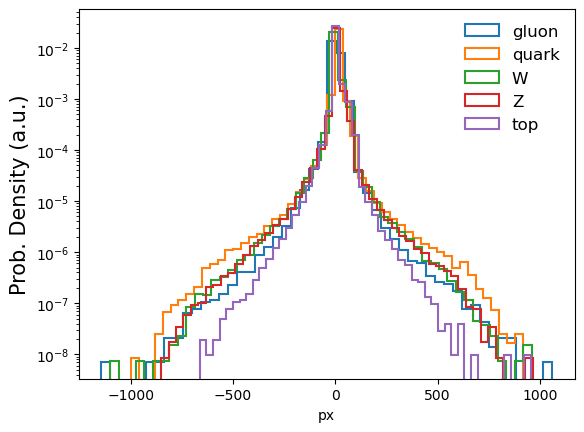

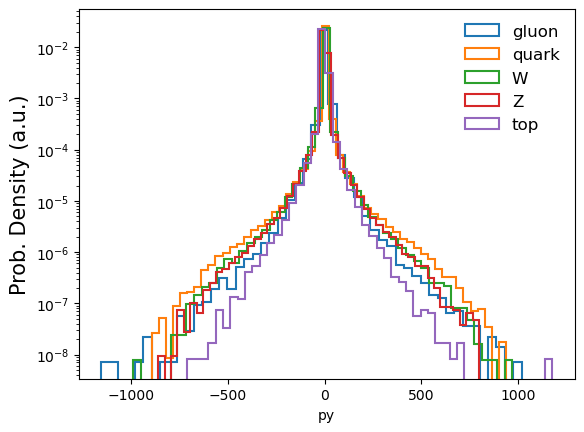

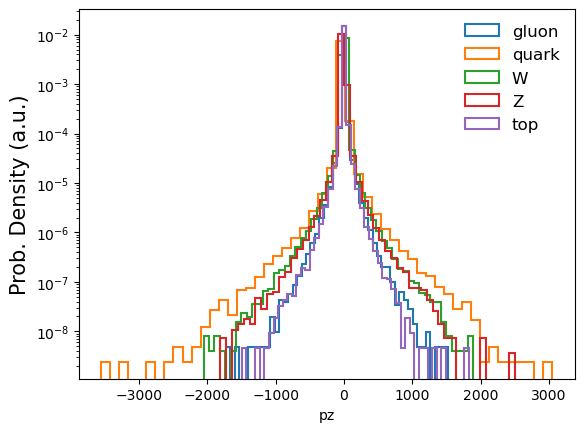

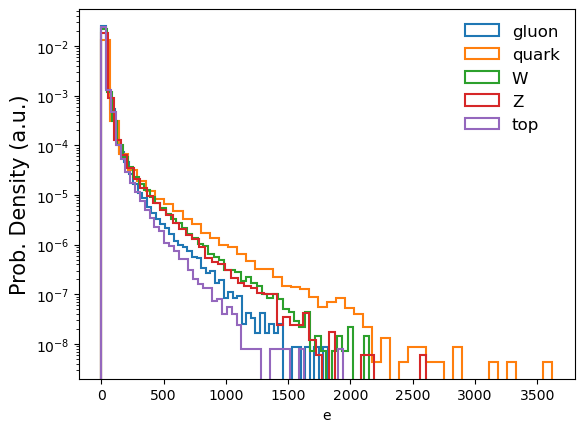

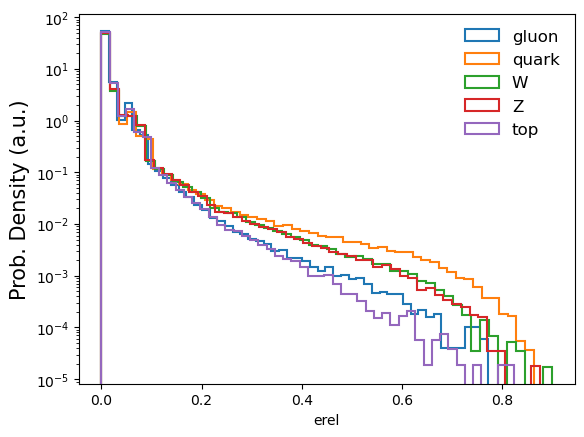

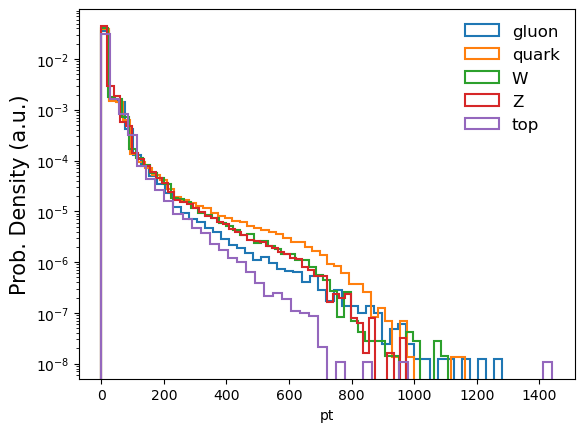

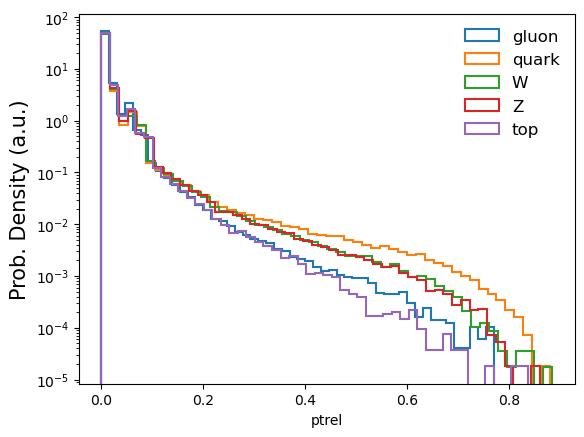

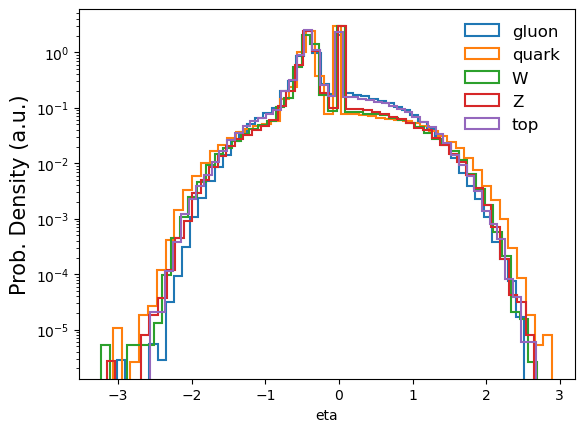

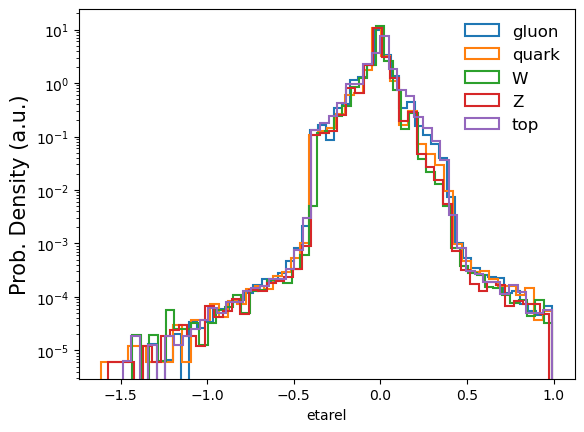

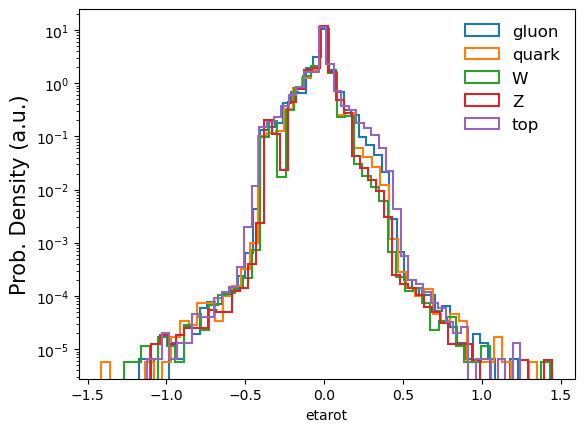

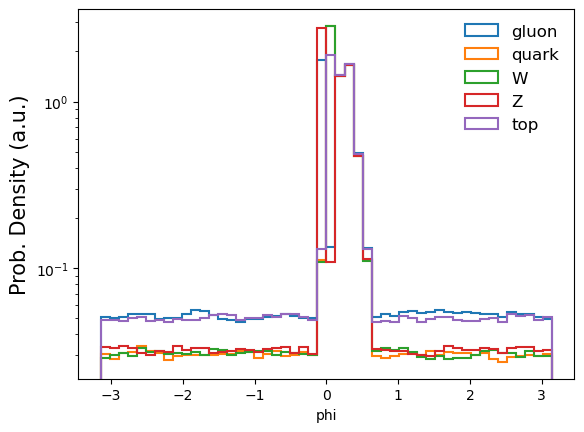

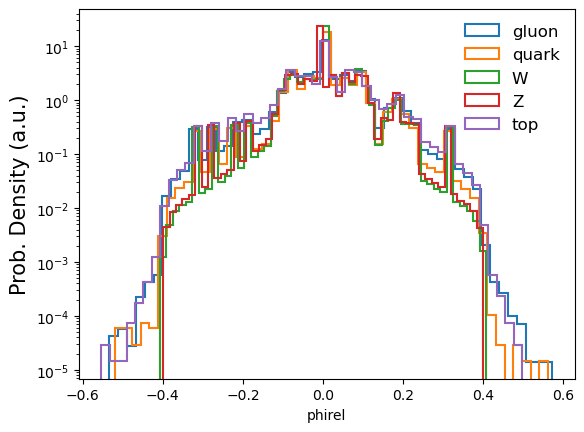

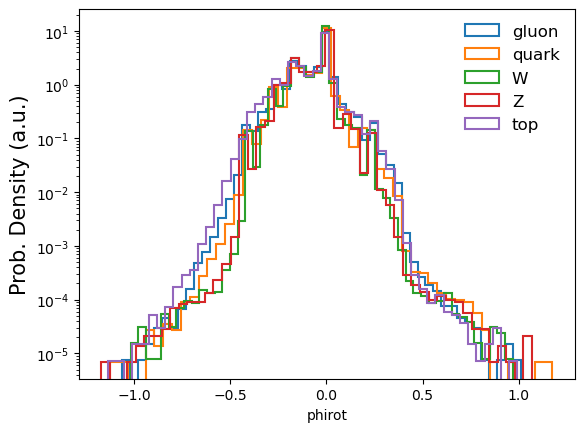

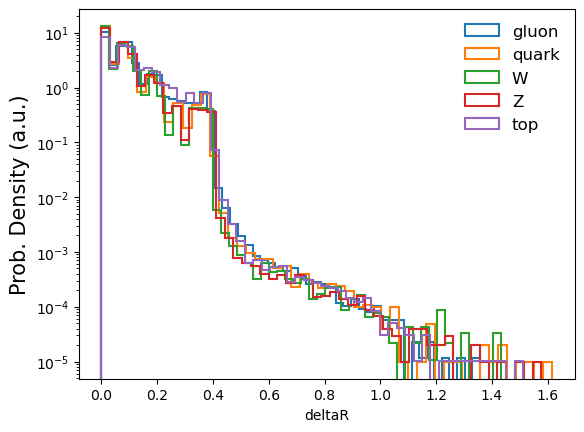

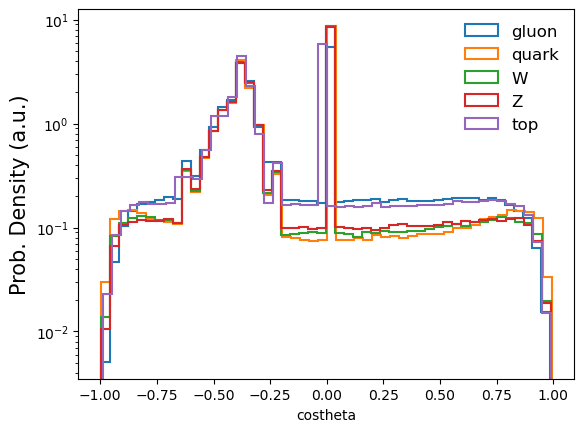

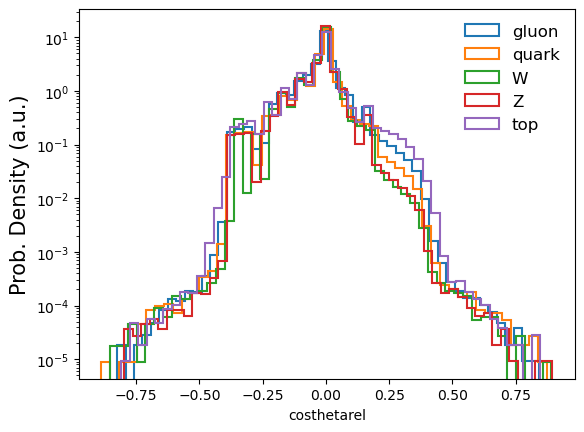

In [9]:
plot_features(features_names)

We are not interested in all features for now. For now we will only consider the same node features as were considered in the ParticleNet paper: 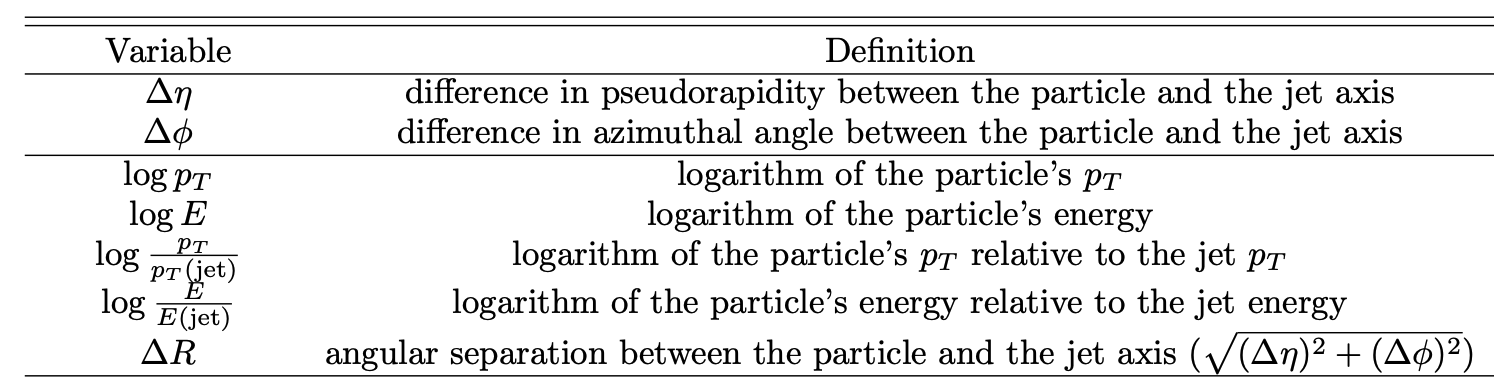

In [10]:
features_to_consider = 'etarel,phirel,pt,e,ptrel,erel,deltaR'.split(',')
features_idx = [features_names[name] for name in features_to_consider]
jetList = jetList[:,:,features_idx]
print(jetList.shape)

(80000, 100, 7)


## Multi Head Attention recap

Assume we have $n$ query vectors (corresponding to the $n$ elements in the set) each with dimension $d_q : Q \in \mathbb{R}^{n\times d_q}$. In the jet tagging dataset $n=100$ and $d_q=7$.

An attention function $\mathrm{Att}(Q,K,V)$ is a function that maps queries $Q$ to outputs using $n_v$ key-value pairs $K \in \mathbb{R}^{n_v \times d_q}, V \in \mathbb{R}^{n_v\times d_v}$:

$$
\mathrm{Att}(Q,K,V;\omega) = \omega(QK^{T})V.
$$

The pairwise dot product $QT^\mathrm{T} \in \mathbb{R}^{n\times n_v}$ measures how similar each pair of query and key vectors is, with weights computed with an activation function $\omega$. The output $\omega(QK^{T})V$ is a weighted sum of $V$ where a value gets more weight if its corresponding key has larger dot product with the query.

Instead of computing a single attention function, the **multi-head attention** method first projects $Q, K, V$ onto $h$ different $d^M_q,d^M_q,d^M_v$-dimensional vectors, respectively. An attention function $\mathrm{Att}(\cdot; \omega_j)$ is applied to each of these $h$ projections. The output is a linear transformation of the concatenation of all attention outputs:

$$
\mathrm{Multihead}(Q, K, V ; \lambda, \omega) = \mathrm{concat}(O_1,..., O_h)W^O
$$

$$
O_j = \mathrm{Att}(QW^Q_j, KW^K_j, VW^V_j ; \omega_j )
$$

In other words, the model tells you what is the score of a particle in the set knowing its interaction with the other particles in the set given all features but in a way that the features are attended separately.

Note that $\mathrm{Multihead}(\cdot, \cdot, \cdot; \lambda)$ has learnable parameters $\lambda =$ {$W^Q_j, W^K_j, W^V_j$}$_{j=1,...,h}$ where $W^Q_j, W^K_j \in \mathbb{R}^{d_q\times d^M_q}, W^V_j \in \mathbb{R}^{d_v\times d^M_v}, W^O \in \mathbb{R}^{hd^M_v\times d}$. A typical choice for the dimension hyperparameters is $d^M_q = d_q /h, d^M_v = d_v /h, d = d_q$. For the Set Transformer we set $d_q = d_v = d$ and $d^M_q = d^M_v = d/h$. A scaled softmax $\omega_j (\cdot) = \mathrm{softmax}(\cdot/\sqrt{d})$ is used.


## Building the Set Transformer

We will implement a simplified version of the [original Set Transformer architecture](https://arxiv.org/abs/1810.00825). The reason is because Transformers are typically computationally and data hungry. As an optional excercise at the end of the notebook you can try to implement the full model and test it on a simpler problem like the MNIST dataset classification (or on a larger jet class dataset).

The architecture is based on the block called `MAB` (= Multihead Attention Block) which implements the following:

$$
\mathrm{MAB}(X, Y) = \mathrm{LayerNorm}(H + \mathrm{rFF}(H))
$$

$$
H = \mathrm{LayerNorm}(X + \mathrm{Multihead}(X, X, X ; ω))
$$

where $X \in \mathbb{R}^{n\times d}$ is the input set and $\mathrm{rFF}$ is any feedforward layer. Since $Q=K=V=X$, the MAB takes a set and performs *self-attention* between the elements in the set, resulting in a set of equal size. Since the output of MAB contains information about pairwise interactions among the elements in the input set $X$, we can stack multiple MABs to encode higher order interactions. This stack is the *encoder* part of the transformer. 

The `LayerNorm` normalizes the activations of a layer across the last dimension (feature dimension) of the input tensor. Specifically, it centers and scales each feature dimension independently by subtracting the mean and dividing by the standard deviation, which are computed over the corresponding feature dimension of the input tensor. As for `BatchNormalization` it has learnable $\gamma$ (scaling) and $\beta$ (shifting) parameters. The difference with respect to `BatchNormalization` is that the normalization is performed indipendently per each instance in the batch. `LayerNorm` leads to improved stability when you expect instances of different sizes (or different zero padding degree as in the jet tagging case).

In [11]:
class MAB(tf.keras.layers.Layer):
    def __init__(self, num_heads, hidden_units, mlp_hidden_units=128, dropout_rate=0.1, **kwargs):
        super(MAB, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.hidden_units = hidden_units
        self.mlp_hidden_units = mlp_hidden_units
    
    def build(self, input_shape):
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads=self.num_heads, 
                                                            key_dim=self.hidden_units//self.num_heads)
        self.feedforward = tf.keras.Sequential([
            layers.Dense(units=self.mlp_hidden_units, activation="relu"),
            layers.Dense(units=input_shape[-1])
        ])
        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)
        super(MAB, self).build(input_shape)
    
    def call(self, inputs, mask=None):
        attention_output = self.attention(inputs, inputs, attention_mask=mask)[0]
        attention_output = self.layer_norm1(inputs + attention_output)
        feedforward_output = self.feedforward(attention_output)
        block_output = self.layer_norm2(attention_output + feedforward_output)
        return block_output

In [12]:
batch_size=128
learning_rate=0.0001
epochs=20

In the original paper, multi-head attention is also applied in the decoder step to obtain a smarter pooling operation. For this excercise we will simplify the model and use instead a `Lambda` layer to apply a custom pooling function to the input tensor. In this case, the `Lambda` layer is being used to sum over the first dimension, i.e. over the elements in the output set of the previous layer, which has shape `(batch_size, n_elements, features)`. By summing over the first dimension (`axis=1`), we obtain a tensor of shape `(batch_size, features)` that represents an aggregation of each feature over the elements in the set.

Here is the full model:

In [13]:
inputs = keras.Input(shape=(100,7), name='input')
x = layers.TimeDistributed(layers.Dense(64))(inputs)
x = MAB(num_heads=8, hidden_units=64)(x)
x = MAB(num_heads=8, hidden_units=64)(x)
x = MAB(num_heads=8, hidden_units=64)(x)
x = layers.Lambda(lambda y: tf.reduce_sum(y, axis=1))(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64)(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(64)(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(16)(x)
x = layers.LeakyReLU()(x)
output_clas = layers.Dense(5, dtype='float32')(x)
#output_reg = layers.Dense(1, dtype='float32')(x)
model = keras.models.Model(inputs=inputs, outputs=output_clas)
model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2023-08-11 00:50:55.274751: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 00:50:55.274830: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-08-11 00:50:55.276731: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:98:00.0 name: NVIDIA A30 computeCapability: 8.0
coreClock: 1.44GHz coreCount: 56 deviceMemorySize: 23.50GiB deviceMemoryBandwidth: 869.04GiB/s
2023-08-11 00:50:55.276755: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-08-11 00:50:55.276782: I tensorflow/stream_executor/platform/default/

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 100, 7)]          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 64)           512       
_________________________________________________________________
mab (MAB)                    (None, 100, 64)           33472     
_________________________________________________________________
mab_1 (MAB)                  (None, 100, 64)           33472     
_________________________________________________________________
mab_2 (MAB)                  (None, 100, 64)           33472     
_________________________________________________________________
lambda (Lambda)              (None, 64)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256   

In [14]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train_class, y_val_class, y_train_reg, y_val_reg, y_train_onehot, y_val_onehot = train_test_split(jetList, target,target_reg, target_onehot, test_size=0.1, shuffle=True)
print(X_train.shape, X_val.shape, y_train_class.shape, y_val_class.shape, y_train_reg.shape, y_val_reg.shape)
del jetList, target, target_onehot

(72000, 100, 7) (8000, 100, 7) (72000,) (8000,) (72000,) (8000,)


In [ ]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2,verbose=1)

We can now plot the validation and training loss evolution over the epochs:

In [ ]:
fig,axes = plt.subplots(2)

axes[0].plot(history.history["sparse_categorical_accuracy"])
axes[0].plot(history.history["val_sparse_categorical_accuracy"])
axes[0].set_title("Accuracy")
axes[0].legend(["Training", "Validation"])

axes[1].plot(history.history["loss"])
axes[1].plot(history.history["val_loss"])
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Loss")

fig.show()



Now we finally evaluate the performance by plotting the ROC curves for the different classes:

In [ ]:
%matplotlib inline
predict_val = tf.nn.softmax(model.predict(X_val))
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}

plt.figure()
for i, label in enumerate(label_names):

        df[label] = y_val_onehot[:,i]
        df[label + '_pred'] = predict_val[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])

        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

As you can see the performance are not as good for other models we have trained on the same dataset. As mentioned at the beginning of the notebook training a transformer might be tricky. You can try the optional excercise below to improve the performance and surpass the other models.

## Optional Excercise

The original paper also use MH mechanism in the decoder step (while we used a simple sum over the latent space nodes). If you would like to try it out the `Lambda` layer should be replaced with the `PoolingByMultiHeadAttention` block below.

Consider also the fact that it might be hard to train a Transformer architecture of this kind over the rather small dataset used here. Check out [this other dataset](https://events.mcs.cmu.edu/us-cms-2023/) for increased statistics or [this notebook](https://github.com/DLii-Research/tf-settransformer/blob/master/examples/mnist_pointcloud.ipynb) for a simpler task.

Below is the starting point for a smarter decoder:

In [ ]:
class PoolingByMultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, hidden_units, mlp_hidden_units=128, num_seeds=1, **kwargs):
        super(PoolingByMultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.hidden_units = hidden_units
        self.mlp_hidden_units = mlp_hidden_units
        self.num_seeds = num_seeds
        
    def build(self, input_shape):
      
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads=self.num_heads, 
                                                            key_dim=self.hidden_units)
        
        self.seed_vectors = self.add_weight(
            shape=(1, self.num_seeds, self.hidden_units),
            initializer="random_normal",
            trainable=True,
            name="Seeds")

        self.feedforward = tf.keras.Sequential([
            layers.Dense(units=self.mlp_hidden_units, activation="relu"),
            layers.Dense(units=self.hidden_units)
        ])
        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)
        super(PoolingByMultiHeadAttention, self).build(input_shape)

    def call(self, inputs, training=None):
        a = tf.expand_dims(self.seed_vectors, axis=0)
        seeds = tf.tile(self.seed_vectors, [tf.shape(inputs)[0], 1, 1])
        attention_output = self.attention(seeds, inputs)[0]
        attention_output = self.layer_norm1(seeds + attention_output)
        feedforward_output = self.feedforward(attention_output)
        block_output = self.layer_norm2(attention_output + feedforward_output)
        return block_output